# Search for HLS data using `pystac_client`

### For debugging HLS querying from LPDAAC STAC

In [1]:
pip install cogeo_mosaic

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')
import plotlib
from mosaiclib import *

In [2]:
import rasterio
from rasterio.plot import show_hist, show
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.__version__

'2.0.2'

## Tests

### NOTE:
if `cogeo_mosaic` has been installed, it bring with it the newest `rio_tiler` which will break this script.  
You want `rio_tiler==6.6.1`

In [22]:
import CovariateUtils

In [23]:
import geopandas as gpd
from mosaiclib import *

In [24]:
import rio_tiler

In [25]:
rio_tiler.__version__

'7.2.2'

In [26]:
boreal_tiles = gpd.read_file('https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg')
#boreal_tiles.explore()

## Wrap `build_ms_composite.py` for testing

In [27]:
# Landsat Collection 2 SR
SAT_API = 'https://landsatlook.usgs.gov/stac-server'
MS_COMP_TYPE = 'LC2SR'

# HLS
SAT_API = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'
MS_COMP_TYPE = 'HLS'

def wrapper_composite(params):

    FOCAL_TILE = params.get('FOCAL_TILE')
    SAT_API = params.get('SAT_API')
    MS_COMP_TYPE = params.get('MS_COMP_TYPE')
    YEAR = params.get('YEAR')
    MIN_N_FILT_RESULTS = params.get('MIN_N_FILT_RESULTS')
    SEASON_START = params.get('SEASON_START')
    SEASON_STOP = params.get('SEASON_STOP')
    # INDEX_FN = params.get('INDEX_FN')
    # INDEX_LYR = params.get('INDEX_LYR')
    STAT = params.get('STAT')
    STAT_PCT = params.get('STAT_PCT')
    TARGET_SPECTRAL = params.get('TARGET_SPECTRAL')

    INDEX_FN =  'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg'
    INDEX_LYR = 'boreal_tiles_v004'
    YEAR_START, YEAR_STOP = (YEAR, YEAR)
    HLS_PRODUCT = 'H30'
    MAX_CLOUDS = 0

    OUTDIR = params.get('OUTDIR') #'/projects/my-private-bucket/tmp/mask_test_keep_snow'
    
    args = f"--in_tile_fn {INDEX_FN} \
        --in_tile_layer {INDEX_LYR} \
        --sat_api {SAT_API} \
        --tile_buffer_m 0 \
        --in_tile_num {FOCAL_TILE} \
        --output_dir {OUTDIR} \
        -sy {YEAR_START} -ey {YEAR_STOP} -smd {SEASON_START} -emd {SEASON_STOP} -mc {MAX_CLOUDS} \
        --composite_type {MS_COMP_TYPE} \
        --hls_product {HLS_PRODUCT} \
        --thresh_min_ndvi -1 \
        --min_n_filt_results {MIN_N_FILT_RESULTS} \
        --stat {STAT} \
        --stat_pct {STAT_PCT} \
        --target_spectral_index {TARGET_SPECTRAL}"
    #args += " --do_indices"
    #args += " --search_only"
    #args += " --rangelims_red 0.01 0.1" # the default now effectively no limit [-1e9, 1e9]
    
    cmd = f'python /projects/code/icesat2_boreal/lib/build_ms_composite.py {args}'
    #!echo $cmd
    !eval $cmd

    fn = f'{OUTDIR}/{MS_COMP_TYPE}_{FOCAL_TILE}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}_{STAT}{TARGET_SPECTRAL}.tif'
    if STAT == 'percentile':
        fn = f'{OUTDIR}/{MS_COMP_TYPE}_{FOCAL_TILE}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}_{STAT}{STAT_PCT}{TARGET_SPECTRAL}.tif'
    #rescaled_multiband_fn = os.path.join(os.path.dirname(fn), os.path.basename(fn).replace('.tif','_rescaled_3band_temp.tif'))
    # plotlib.rescale_multiband_for_plot(fn, rescaled_multiband_fn, bandlist = [5,7,3], pct=[20,90], nodata=-9999.0) 

    return fn

## Test Build MS Composite (new version of 3.1.2)

TODO:  
+ Fix 0 values coming out of comp when a pixel slice is all NaN. Need this to be NaN.
+ adjust red_rangelims : change for winter comps; are they even needed in any comps?
+ adjust min ndvi thresh
+ test for tiles with ocean
+ test for Landsat 5/7 comps

### Learned details:  
+ put flag that would turn on snow/ice masking for summer comps - this way, that nodata could be masked all pixels down through the stack across all seasons. But dont do this for winter, fall seasons.

## Current testing: `build_ms_composite.py`


In [28]:
MIN_N = 10

#OUTDIR = f'/projects/my-private-bucket/tmp/test_percentile_n{MIN_N:02}'
#OUTDIR = f'/projects/my-private-bucket/tmp/test_max_anyseason_n{MIN_N:02}'

args_dict_septoct = {
    'SAT_API': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD', 
    'MS_COMP_TYPE': 'HLS',
    'YEAR': 2024, 
    'MIN_N_FILT_RESULTS': MIN_N,
    'SEASON_START': '09-01',
    'SEASON_STOP': '10-31',
    'OUTDIR': '',
    'TARGET_SPECTRAL': ''
}
args_dict_julyaug = {
    'SAT_API': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD', 
    'MS_COMP_TYPE': 'HLS',
    'YEAR': 2024, 
    'MIN_N_FILT_RESULTS': MIN_N, ###< ----------------------
    'SEASON_START': '07-01',
    'SEASON_STOP': '08-31',
    'OUTDIR': '',
    'TARGET_SPECTRAL': ''
}
args_dict_marchapril = {
    'SAT_API': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD', 
    'MS_COMP_TYPE': 'HLS',
    'YEAR': 2024, 
    'MIN_N_FILT_RESULTS': MIN_N, ###< ----------------------
    'SEASON_START': '03-01',
    'SEASON_STOP': '04-30',
    'OUTDIR': '',
    'TARGET_SPECTRAL': ''
}
#print(OUTDIR)

In [38]:
YEAR_LIST = [2019] #[2016,2022,2025]
FOCAL_TILE_LIST = [3366] # [3273] #[41248] #[936] #,3266,,3458,3457,37743]
STAT = 'max'
TARGET_SPECTRAL = 'ndvi'
OUTDIR = f'/projects/my-private-bucket/tmp/test_{STAT}{TARGET_SPECTRAL}_anyseason_n{MIN_N:02}'

In [30]:
params_list = []
for YEAR in YEAR_LIST:
    for FOCAL_TILE in FOCAL_TILE_LIST:
        params_d_list = []
        #params_d_list.append(args_dict_marchapril.copy())
        params_d_list.append(args_dict_julyaug.copy())
        #params_d_list.append(args_dict_septoct.copy())

        for params in params_d_list:
            
            params['OUTDIR'] = OUTDIR
            params['TARGET_SPECTRAL'] = TARGET_SPECTRAL
            params['FOCAL_TILE'] = FOCAL_TILE
            params['YEAR'] = YEAR
            params['STAT'] = STAT
            params['STAT_PCT'] = 50.0
            
            params_list += [params]   

In [31]:
len(params_list)

1

In [13]:
from multiprocessing import Pool
from functools import partial

#### Multiprocess...

In [14]:
%%time
with Pool(processes=3) as pool:
    fn_list = pool.map(wrapper_composite, params_list)


Tiles path:		 https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg
Tile number:		 3366
Output res (m):		 30
in_bbox:		 [1538521.9999999953, 3123304.0000000093, 1628521.9999999953, 3213304.0000000093]
bbox 4326:		 [-146.1345823219171, 64.09608167288994, -143.52799622821706, 65.18379990439044]
Getting output dims from buffered (buffer=0.0) original tile geometry...
Output dims:		3000 x 3000
Composite type:		HLS

Getting HLS Surface Reflectance H30 data...
bbox: [-146.1345823219171, 64.09608167288994, -143.52799622821706, 65.18379990439044]

Querying STAC for multispectral imagery...
Catalog title: LPCLOUD STAC Catalog
start date, end date:		 2019-07-01T00:00:00Z 2019-08-31T23:59:59Z

Conducting multispectral image search now ...
Searching for:			['HLSL30_2.0', 'HLSS30_2.0']
Max cloudcover threshold starts at: 0% and won't exceed 90%
Min number of filtered results: 10
partial results (HLSL30_2.0):				0
partial results (HLSS30_2.0):				0
	Only 0 HLS

#### Single process....

In [35]:
params = args_dict_marchapril.copy()

params['FOCAL_TILE'] = 3266 #41248 # in 2021 this comp is bad - see if still bad #3458 #3457 #37743 #936
params['YEAR'] = 2022
params['STAT'] = 'max'
params['STAT_PCT'] = 50.0

In [41]:
params['OUTDIR'] = OUTDIR
params

{'SAT_API': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD',
 'MS_COMP_TYPE': 'HLS',
 'YEAR': 2022,
 'MIN_N_FILT_RESULTS': 10,
 'SEASON_START': '03-01',
 'SEASON_STOP': '04-30',
 'OUTDIR': '/projects/my-private-bucket/tmp/test_maxndvi_anyseason_n10',
 'TARGET_SPECTRAL': '',
 'FOCAL_TILE': 3266,
 'STAT': 'max',
 'STAT_PCT': 50.0}

In [42]:
%%time

fn = wrapper_composite(params)


Tiles path:		 https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg
Tile number:		 3266
Output res (m):		 30
in_bbox:		 [908521.9999999953, 3213304.0000000093, 998521.9999999953, 3303304.0000000093]
bbox 4326:		 [-158.18646735598986, 67.21374690426187, -155.44393386322625, 68.23778684014917]
Getting output dims from buffered (buffer=0.0) original tile geometry...
Output dims:		3000 x 3000
Composite type:		HLS

Getting HLS Surface Reflectance H30 data...
bbox: [-158.18646735598986, 67.21374690426187, -155.44393386322625, 68.23778684014917]

Querying STAC for multispectral imagery...
Catalog title: LPCLOUD STAC Catalog
start date, end date:		 2022-03-01T00:00:00Z 2022-04-30T23:59:59Z

Conducting multispectral image search now ...
Searching for:			['HLSL30_2.0', 'HLSS30_2.0']
Max cloudcover threshold starts at: 0% and won't exceed 90%
Min number of filtered results: 10
partial results (HLSL30_2.0):				9
partial results (HLSS30_2.0):				10
compelte r

In [34]:
fn = fn_list[0] #= '/projects/my-private-bucket/tmp/mask_test_keep_snow/HLS_3458_03-01_04-30_2024_2024_percentile50.0.tif'
fn

'/projects/my-private-bucket/tmp/test_maxndvi_anyseason_n10/HLS_3366_07-01_08-31_2019_2019_maxndvi.tif'

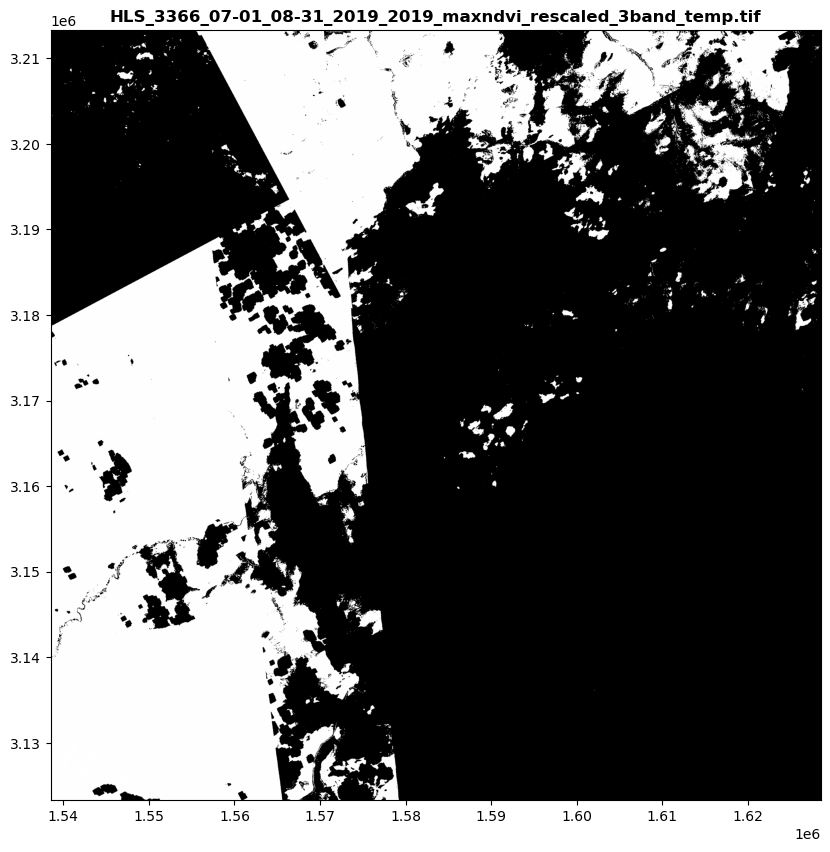

In [18]:
rescaled_multiband_fn = fn.replace('.tif', '_rescaled_3band_temp.tif')

plotlib.rescale_multiband_for_plot(fn, rescaled_multiband_fn, bandlist = [6,4,3], pct=[20,98], nodata=-9999.0) 

fig,ax=plt.subplots(figsize=(10,10))
with rasterio.open(rescaled_multiband_fn) as src:
    #print(src.profile)
    show(src.read(),transform=src.transform, ax=ax, title=os.path.basename(rescaled_multiband_fn))

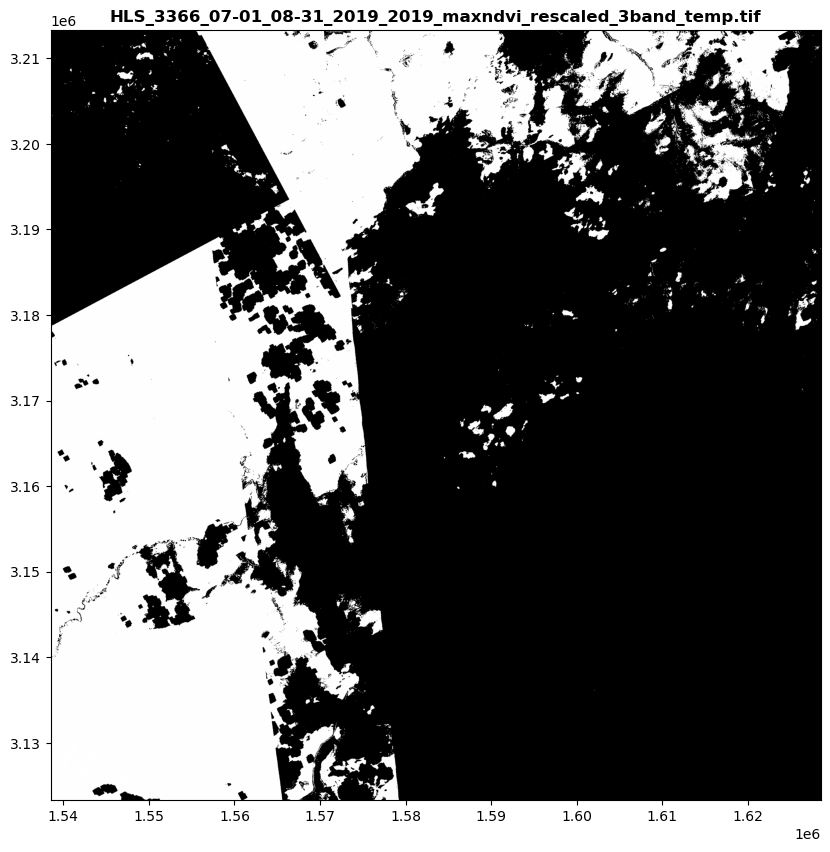

In [19]:
rescaled_multiband_fn = fn.replace('.tif', '_rescaled_3band_temp.tif')

plotlib.rescale_multiband_for_plot(fn, rescaled_multiband_fn, bandlist = [6,4,3], pct=[20,98], nodata=-9999.0) 

fig,ax=plt.subplots(figsize=(10,10))
with rasterio.open(rescaled_multiband_fn) as src:
    #print(src.profile)
    show(src.read(),transform=src.transform, ax=ax, title=os.path.basename(rescaled_multiband_fn))